https://github.com/googleapis/python-bigquery-dataframes/blob/main/notebooks/getting_started/getting_started_bq_dataframes.ipynb
* BigQuery API
* BigQuery Connection API
* Cloud Functions API
* Cloud Run API
* Artifact Registry API
* Cloud Build API
* Cloud Resource Manager API
* Vertex AI API
* Gemini

In [48]:
import json
import re

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import bigframes
import bigframes.bigquery as bbq
import bigframes.pandas as bpd
from bigframes.ml.cluster import KMeans
from bigframes.ml.decomposition import PCA
from bigframes.ml.llm import GeminiTextGenerator
from bigframes.ml.llm import TextEmbeddingGenerator
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import userdata

PROJECT_ID = "bq-hackathon-hk"
LOCATION = "europe-west4"  # In Frankfurt gibts anscheinend nicht so viele AI-Modelle, deshalb Belgien
RAW_DATA_URI = "gs://bq_public_bucket/sap_hcm_questions.jsonl"

DATASET_ID = f"{PROJECT_ID}.bq_dataset"
RAW_TABLE_ID = f"{DATASET_ID}.bq_table"
QUESTION_SUMMARY_TABLE_ID = f"{DATASET_ID}.bq_table_question_summary"
EMBEDDINGS_TABLE_ID = f"{DATASET_ID}.bq_table_embeddings"
CLUSTER_TABLE_ID = f"{DATASET_ID}.bq_table_cluster"
CLUSTER_REPRESENTATIVES_ID = f"{DATASET_ID}.bq_table_cluster_representatives"
CLUSTER_LLM_TABLE_ID = f"{DATASET_ID}.bq_table_cluster_llm"
CENTROIDS_TABLE_ID = f"{DATASET_ID}.bq_table_centroids"
CANDIDATE_PCA_TABLE_ID = f"{DATASET_ID}.bq_table_candidate_pca"
CLUSTER_LABELS_TABLE_ID = f"{DATASET_ID}.bq_table_cluster_labels"

CLUSTER_MONTHLY_TABLE_ID   = f"{DATASET_ID}.bq_table_cluster_shares_monthly"
CLUSTER_QUARTERLY_TABLE_ID = f"{DATASET_ID}.bq_table_cluster_shares_quarterly"

EMBEDDING_MODEL_ID =f"{DATASET_ID}.embedding_model"
QUESTION_SUMMARY_EMBEDDING_PCA_MODEL_ID =f"{DATASET_ID}.question_summary_embedding_pca_model"
CLUSTER_KMEANS_MODEL_ID =f"{DATASET_ID}.cluster_kmeans_model"

# TEXT_SEARCH_STRING = "How can holiday entitlement be carried over to the next year?"
TOP_LABELS_PER_CLUSTER = 3

QUESTION_SUMMARY_PROMPT_PREFIX = (
    "You are summarizing SAP HCM (including SuccessFactors) forum posts for vector clustering.\n\n"
    "TASK: Write ONE concise English sentence (≈35–45 words) capturing:\n"
    "- SAP product (ECC, H4S4, On-Prem, SuccessFactors, CPI/BTP, IAS/IPS, Enable Now, Web Assistant, E-Recruiting, HCM On-Prem; use 'Cross-product' if mixed).\n"
    "- Module/area (canonical names: EC, EC Time Off, Compensation, Variable Pay, PM/GM, RCM, RMK/CSB, ONB, LMS, WFA, IAS/IPS, CPI/BTP, Enable Now, Web Assistant, E-Recruiting, HCM On-Prem; use 'Cross-module' if mixed).\n"
    "- Concrete feature/object (e.g., business rule trigger, picklist, permissions, cookie consent manager, SCORM tracking, PTMW, T512Z).\n"
    "- Author’s intent: incident (observed vs expected), how-to/configuration, design/architecture, programming/integration, reporting/analytics, or policy/process.\n\n"
    "STYLE RULES:\n"
    "- Start with '<Product> - <Module>: <feature> — <intent phrasing>' when clear; omit prefix only if truly unknown.\n"
    "- No user/greeting phrases, no requests for help, no URLs, no IDs/emails, no quotes.\n"
    "- Use precise nouns/verbs; avoid generic words: issue, problem, question, help, setup, configuration, general, request.\n"
    "- Include exact error codes or table/transaction names if present (e.g., HRTIM_ABS_REQ/013, T512Z, PTMW) but nothing sensitive.\n\n"
    "RETURN: Only the single sentence. No extra text.\n\n"
)

In [ ]:
def load_service_credentials_from_colab():
    """Load service account credentials stored in Colab user data."""
    secret_json = userdata.get("GCP_SECRET_KEY")
    return service_account.Credentials.from_service_account_info(json.loads(secret_json))


def initialize_bigquery_client(credentials, project_id, location):
    """Create a BigQuery client for the configured project and location."""
    return bigquery.Client(
        location=location,
        credentials=credentials,
        project=project_id,
    )


def ensure_dataset(bigquery_client, dataset_id):
    """Ensure the dataset exists and return its reference."""
    dataset = bigquery.Dataset(dataset_id)
    dataset = bigquery_client.create_dataset(dataset, timeout=30, exists_ok=True)
    print(f"Created dataset {bigquery_client.project}.{dataset.dataset_id}")
    return dataset


def ensure_source_table(bigquery_client, table_id, location, source_uri):
    """Load the raw JSON data into BigQuery if the table is missing."""
    try:
        table = bigquery_client.get_table(table_id)
        print(f"Table with {table.num_rows} rows already there.")
    except Exception:
        job_config = bigquery.LoadJobConfig(
            autodetect=True,
            source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
        )
        load_job = bigquery_client.load_table_from_uri(
            source_uri,
            table_id,
            location=location,
            job_config=job_config,
        )
        load_job.result()
        table = bigquery_client.get_table(table_id)
        print(f"Loaded {table.num_rows} rows.")

    return bpd.read_gbq(table_id, use_cache=False)


def configure_bigframes_session(project_id, location):
    """Configure global BigFrames and pandas options for the project."""
    bpd.options.bigquery.project = project_id
    bpd.options.bigquery.location = location
    bigframes.options.bigquery.project = project_id
    bigframes.options.bigquery.location = location


# Authenticate and initialize
service_credentials = load_service_credentials_from_colab()
bigquery_client = initialize_bigquery_client(service_credentials, PROJECT_ID, LOCATION)
configure_bigframes_session(PROJECT_ID, LOCATION)

# ensure source data is available
ensure_dataset(bigquery_client, DATASET_ID)
question_dataframe = ensure_source_table(bigquery_client, RAW_TABLE_ID, LOCATION, RAW_DATA_URI)
question_dataframe.peek()

Created dataset bq-hackathon-hk.bq_dataset
Table with 15617 rows already there.


,reply_count,board,updated_at,author,published_at,tags,url,question_text,title,answers,question_upvotes,content_type,lastmod_from_sitemap
7,1,hcm-questions,2022-11-04 10:28:07+00:00,poornachandra03,2022-10-28 02:12:55+00:00,['SAP SuccessFactors HCM Core'],https://community.sap.com/t5/human-capital-man...,"Hello, I need your suggestion on the below l...",Is it possible to auto populate the decimal va...,"[{'upvotes': 0, 'created_at': datetime.datetim...",0,qna,2022-10-28 02:12:55+00:00
34,1,hcm-questions,2020-12-16 00:46:43+00:00,former_member,2020-12-15 21:28:27+00:00,"['SAP Enable Now, author option']",https://community.sap.com/t5/human-capital-man...,"Hello, Please let me know if there is any way...",Import a SCORM file into Enable Now,"[{'upvotes': 1, 'created_at': datetime.datetim...",0,qna,2020-12-15 21:28:27+00:00
87,1,hcm-questions,2023-07-05 10:08:27+00:00,Andrew86,2023-06-27 12:38:21+00:00,['integration' 'SAP Companion' 'SAP SuccessFac...,https://community.sap.com/t5/human-capital-man...,Do others using SAP Companion see the value in...,SAP Enable Now - SAP Companion support for SF ...,"[{'upvotes': 0, 'created_at': datetime.datetim...",0,qna,2023-06-27 12:38:21+00:00
234,6,hcm-questions,2023-05-02 08:50:28+00:00,lushcacomley,2023-04-04 00:52:00+00:00,['SAP SuccessFactors HCM Suite'],https://community.sap.com/t5/human-capital-man...,Hi Does anyone know when the release notes a...,H1 2023 - Release notes release date,"[{'upvotes': 0, 'created_at': datetime.datetim...",0,qna,2023-04-04 00:52:00+00:00
280,1,hcm-questions,2024-08-27 22:54:26+00:00,DoraK,2024-08-27 10:31:22.082000+00:00,['SAP SuccessFactors Employee Central'],https://community.sap.com/t5/human-capital-man...,"Hello Everyone, we are looking into to impleme...",Position management- Shared Positions vs Regular,"[{'upvotes': 0, 'created_at': datetime.datetim...",0,qna,2024-08-27 22:54:26+00:00


In [ ]:
def create_summary_prompts(question_dataframe):
    """Combine title, tags, and question text into a single prompt per row."""
    prompt_series = (
        QUESTION_SUMMARY_PROMPT_PREFIX
        + "{title: \""
        + question_dataframe["title"]
        + "\","
        + "tags: ["
        + bbq.array_to_string(question_dataframe["tags"], delimiter=", ")
        + "],"
        + "question_text: \""
        + question_dataframe["question_text"]
        + "\"}"
    )
    return prompt_series


def generate_question_summaries(question_dataframe, llm_model):
    """Use Gemini to add concise summaries for each question."""
    summary_prompts = create_summary_prompts(question_dataframe)
    summary_predictions = llm_model.predict(summary_prompts, temperature=0.2, max_output_tokens=300)
    question_dataframe["question_summary"] = summary_predictions["ml_generate_text_llm_result"]
    return question_dataframe


def load_or_generate_question_summaries(question_dataframe, llm_model, summary_table_id):
    """Reuse persisted question summaries when available, otherwise generate and store them."""
    try:
        summary_dataframe = bpd.read_gbq(summary_table_id, use_cache=False)
        print("read question summaries from db")
        return summary_dataframe
    except Exception:
        print("question summary table not found -> generating summaries")
        summarized_dataframe = generate_question_summaries(question_dataframe, llm_model)
        summarized_dataframe.to_gbq(summary_table_id, if_exists="replace")
        print("saved question summaries table")
        return summarized_dataframe



# Generate human-readable summaries for each question.
llm_model = GeminiTextGenerator(model_name="gemini-2.0-flash-001")
question_dataframe = load_or_generate_question_summaries(
    question_dataframe,
    llm_model,
    QUESTION_SUMMARY_TABLE_ID,
)
question_dataframe.peek(5)

read question summaries from db


,reply_count,board,updated_at,author,published_at,tags,url,question_text,title,answers,question_upvotes,content_type,lastmod_from_sitemap,question_summary
148,0,hcm-questions,2025-06-16 13:16:04+00:00,anubhav09,2025-06-16 13:16:04.381000+00:00,['API for Cost Center Replication to Successfa...,https://community.sap.com/t5/human-capital-man...,I'm reaching out to gather your inputs on the ...,Do we have any SAP standard pre-delivered API ...,[],0,qna,2025-06-16 13:16:04+00:00,SAP ECC - CPI/BTP: Cost Center replication via...
447,0,hcm-questions,2023-10-05 05:49:30+00:00,assravichandr,2023-10-05 05:49:30+00:00,['Connectors' 'Email notification' 'SAP Succes...,https://community.sap.com/t5/human-capital-man...,"Hi Experts, I just wanted to know if there is...",Customizing LMS - Connector Email Report,[],0,qna,2023-10-05 05:49:30+00:00,SuccessFactors - LMS: Connector email report c...
515,1,hcm-questions,2019-10-08 13:10:23+00:00,former_member,2017-04-11 13:31:30+00:00,['SAP SuccessFactors HCM Suite'],https://community.sap.com/t5/human-capital-man...,I am attempting to login to success factors by...,How do I find the company ID?,"[{'upvotes': 0, 'created_at': datetime.datetim...",0,qna,2017-04-11 13:31:30+00:00,SuccessFactors - LMS: Company ID for accessing...
834,1,hcm-questions,2021-10-12 06:50:29+00:00,former_member,2021-10-12 06:50:09+00:00,['Employee Experience Management'],https://community.sap.com/t5/human-capital-man...,Our career/ jobs website is a SAP SuccessFacto...,Can AEM ( Adobe experience forms) be integrate...,"[{'upvotes': 0, 'created_at': datetime.datetim...",0,qna,2021-10-12 06:50:09+00:00,SuccessFactors - RCM: AEM Forms integration wi...
845,0,hcm-questions,2025-05-21 15:18:33+00:00,RHTI,2025-05-21 15:18:33.832000+00:00,['SAP SuccessFactors Recruiting'],https://community.sap.com/t5/human-capital-man...,Hello Community Have you had difficulty viewi...,Manage pending hires,[],0,qna,2025-05-21 15:18:33+00:00,SuccessFactors - RCM: Intermittent visibility ...


In [49]:
def load_or_generate_embeddings(question_dataframe, embedding_generator, embeddings_table_id):
    """Load embeddings from BigQuery or generate them when missing."""
    try:
        loaded_df = bpd.read_gbq(embeddings_table_id, use_cache=False)
        print("read embeddings from db")
        return loaded_df
    except:
        print("table with embeddings not found -> creating embeddings")
        embedding_predictions = embedding_generator.predict(question_dataframe["question_summary"])
        print("done generatig embeddings")
        question_dataframe["embeddings"] = embedding_predictions["ml_generate_embedding_result"]

        display(question_dataframe["embeddings"].list.len().value_counts(dropna = False))
        embeddings_size = question_dataframe["embeddings"].list.len().max()
        question_dataframe = question_dataframe[question_dataframe["embeddings"].list.len() == embeddings_size]
        question_dataframe.to_gbq(
            embeddings_table_id,
            if_exists="replace",
        )
        print("saved BQ table")
        if question_dataframe["embeddings"].shape[0] > 5000:
            bbq.create_vector_index(
                table_id=embeddings_table_id,
                column_name="embeddings",
                replace=True,
                index_name="embeddings_index",
                distance_type="cosine",
                index_type="ivf",
            )
            print("created vector index")
        return question_dataframe


# Reuse or build embeddings for semantic search and clustering.
embedding_generator = TextEmbeddingGenerator(model_name="text-embedding-005")
embedding_generator.to_gbq(EMBEDDING_MODEL_ID, replace=True)
question_dataframe = load_or_generate_embeddings(question_dataframe, embedding_generator, EMBEDDINGS_TABLE_ID)


read embeddings from db


In [ ]:
# Execute a semantic search example and summarize the findings.
# _, top_articles_json = run_vector_search(embedding_generator, TEXT_SEARCH_STRING, EMBEDDINGS_TABLE_ID)
# summarize_search_results(llm_model, TEXT_SEARCH_STRING, top_articles_json)

In [ ]:
def principal_components_to_array(component_dataframe):
    """Convert PCA component columns into a BigQuery ARRAY while preserving order."""
    principal_columns = [
        column for column in component_dataframe.columns if column.startswith("principal_component_")
    ]
    principal_columns.sort(key=lambda name: int(re.search(r"\d+$", name).group()))
    placeholders = ", ".join(f"{{{index}}}" for index in range(len(principal_columns)))
    return bbq.sql_scalar(f"ARRAY[{placeholders}]", columns=[component_dataframe[column] for column in principal_columns])


def project_embeddings_to_pca(question_dataframe):
    """Reduce embedding dimensionality with PCA and append the projected vectors."""
    pca_model = None
    try:
      pca_model = bpd.read_gbq_model(
          QUESTION_SUMMARY_EMBEDDING_PCA_MODEL_ID
      )
      print("read PCA model from db")
    except:
      pca_model = PCA(n_components=0.95).fit(question_dataframe["embeddings"])
      pca_model.to_gbq(QUESTION_SUMMARY_EMBEDDING_PCA_MODEL_ID, replace = True)
      component_count = pca_model.explained_variance_ratio_.shape[0]
      explained_variance = pca_model.explained_variance_ratio_.sum()["explained_variance_ratio"] * 100
      print(f"Finished PCA with {component_count} components -> explained variance: {explained_variance} %")

    projected_embeddings = pca_model.predict(question_dataframe["embeddings"])
    projected_array = principal_components_to_array(projected_embeddings)
    print("done projecting embeddings to pca space")
    question_dataframe = question_dataframe.assign(embeddings_pca=projected_array)
    return question_dataframe, pca_model



# Project embeddings into PCA space to prepare for clustering.
question_dataframe, pca_model = project_embeddings_to_pca(question_dataframe)
# Reference values for different variance thresholds:
#   138 components -> 90 %
#   248 components -> 95 %
#   468 components -> 99 %


read PCA model from db


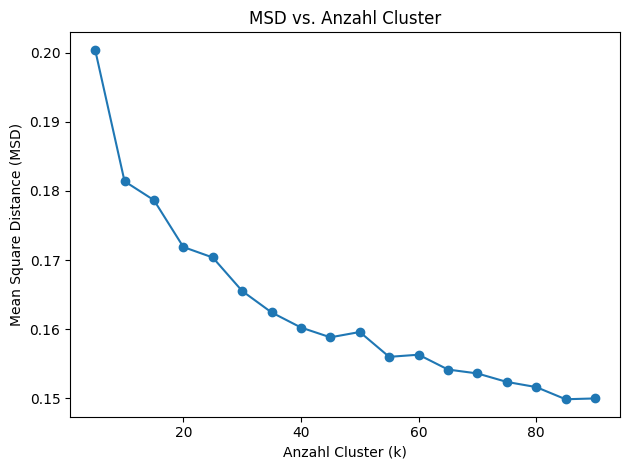

In [ ]:
def evaluate_cluster_candidates(question_dataframe, candidate_range):
    """Train multiple KMeans models and collect their evaluation metrics."""
    cluster_scores = []
    for cluster_count in candidate_range:
        print(f"Running KMeans with {cluster_count} clusters...")
        cluster_model = KMeans(n_clusters=cluster_count, distance_type="cosine")
        cluster_model.fit(question_dataframe["embeddings_pca"])
        score = cluster_model.score(question_dataframe["embeddings_pca"])
        cluster_scores.append(
            {
                "n_clusters": cluster_count,
                "davies_bouldin_index": score.at[0, "davies_bouldin_index"],
                "mean_squared_distance": score.at[0, "mean_squared_distance"],
            }
        )
        print(f"Finished KMeans with {cluster_count} clusters.")
    cluster_scores_dataframe = pd.DataFrame(cluster_scores)
    return cluster_scores_dataframe



# Evaluate several KMeans configurations and train the final model.
# cluster_scores = evaluate_cluster_candidates(question_dataframe, range(5, 91, 5))
# display(cluster_scores)

# Daten vorbereiten
data = [
    (5, 3.762453, 0.200403),
    (10, 3.035111, 0.181390),
    (15, 3.456175, 0.178657),
    (20, 3.430315, 0.171883),
    (25, 3.391992, 0.170367),
    (30, 3.504140, 0.165523),
    (35, 3.483658, 0.162425),
    (40, 3.425847, 0.160240),
    (45, 3.497184, 0.158822),
    (50, 3.662195, 0.159593),
    (55, 3.607168, 0.156000),
    (60, 3.489764, 0.156309),
    (65, 3.645876, 0.154162),
    (70, 3.374113, 0.153599),
    (75, 3.358250, 0.152373),
    (80, 3.450252, 0.151627),
    (85, 3.445500, 0.149867),
    (90, 3.364984, 0.149985),
]
df = pd.DataFrame(data, columns=["n_cluster", "dbi", "msd"]).sort_values("n_cluster")

# MSD-Liniendiagramm
ax = df.plot(x="n_cluster", y="msd", kind="line", marker="o", legend=False)
ax.set_xlabel("Anzahl Cluster (k)")
ax.set_ylabel("Mean Square Distance (MSD)")
ax.set_title("MSD vs. Anzahl Cluster")
plt.tight_layout()
plt.show()



In [ ]:
def create_cluster_assignments(question_dataframe, cluster_count):
    """Fit the final KMeans model and persist assignments to BigQuery."""

    cluster_model = None
    try:
      cluster_model = bpd.read_gbq_model(
          CLUSTER_KMEANS_MODEL_ID
      )
      print("read KMeans model from db")
    except:
      print(f"Running KMeans with {cluster_count} clusters...")
      cluster_model = KMeans(n_clusters=cluster_count, distance_type="cosine")
      cluster_model.fit(question_dataframe["embeddings_pca"])
      print(f"Finished KMeans with {cluster_count} clusters.")

      cluster_model.to_gbq_model(CLUSTER_KMEANS_MODEL_ID, replace=True)

    print("create cluster assignments")
    cluster_assignments = cluster_model.predict(question_dataframe)
    cluster_assignments["CENTROID_ID"].value_counts().describe()
    cluster_assignments.to_gbq(CLUSTER_TABLE_ID, if_exists="replace")
    return cluster_assignments


FINAL_CLUSTER_COUNT = 45
cluster_assignments = create_cluster_assignments(question_dataframe, FINAL_CLUSTER_COUNT)
cluster_assignments["CENTROID_ID"].value_counts().describe()

Running KMeans with 45 clusters...


Finished KMeans with 45 clusters.


count          45.0
mean     346.466667
std       229.90152
min            61.0
25%           158.0
50%           316.0
75%           448.0
max           918.0
Name: count, dtype: Float64

In [ ]:
def create_cluster_representatives(cluster_table_id, cluster_representatives_id, top_k):
    """Select representative question summaries per cluster centroid."""
    representatives = bpd.read_gbq(
        f"""
WITH centroids AS (
  WITH exploded AS (
    SELECT
      CENTROID_ID,
      OFFSET AS i,
      val
    FROM `{cluster_table_id}`,
    UNNEST(embeddings_pca) AS val WITH OFFSET
  ),
  avgd AS (
    SELECT CENTROID_ID, i, AVG(val) AS mean_val
    FROM exploded
    GROUP BY CENTROID_ID, i
  )
  SELECT
    CENTROID_ID,
    ARRAY_AGG(mean_val ORDER BY i) AS centroid_pca
  FROM avgd
  GROUP BY CENTROID_ID
),
doc AS (
  SELECT
    CENTROID_ID,
    question_summary,
    embeddings_pca,
    (SELECT SQRT(SUM(POW(x, 2))) FROM UNNEST(embeddings_pca) AS x) AS norm_r
  FROM `{cluster_table_id}`
),
cen AS (
  SELECT
    CENTROID_ID,
    centroid_pca,
    (SELECT SQRT(SUM(POW(x, 2))) FROM UNNEST(centroid_pca) AS x) AS norm_c
  FROM centroids
),
cos AS (
  SELECT
    d.CENTROID_ID,
    d.question_summary,
    (SELECT SUM(rv * cv)
       FROM UNNEST(d.embeddings_pca) AS rv WITH OFFSET i
       JOIN UNNEST(c.centroid_pca) AS cv WITH OFFSET j
       ON i = j
    ) / NULLIF(d.norm_r * c.norm_c, 0) AS cosine_sim
  FROM doc d
  JOIN cen c USING (CENTROID_ID)
),
ranked AS (
  SELECT
    CENTROID_ID,
    question_summary,
    1.0 - cosine_sim AS cosine_distance,
    ROW_NUMBER() OVER (
      PARTITION BY CENTROID_ID
      ORDER BY 1.0 - cosine_sim ASC
    ) AS rn
  FROM cos
)
SELECT *
FROM ranked
WHERE rn <= {top_k}
"""
    )
    representatives.to_gbq(cluster_representatives_id, if_exists="replace")
    return representatives


def build_cluster_label_prompts(cluster_representatives_id):
    """Assemble labeling prompts for each cluster based on representative summaries."""
    prompts = bpd.read_gbq(
        f"""
SELECT
  CENTROID_ID,
  CONCAT(
    'You are labeling clusters of SAP SuccessFactors support summaries.', CHR(10),
    'TASK: Propose 12 concise candidate topic labels for this cluster.', CHR(10),
    'FORMAT: Return a JSON array of 12 strings. No extra text.', CHR(10),
    'NAMING:', CHR(10),
    '- Use "Prefix: Topic" where Prefix ∈ {{EC, EC Time Off, Compensation, Variable Pay, PM/GM, RCM, RMK/CSB, ONB, LMS, WFA, IAS/IPS, CPI/BTP, Enable Now, Web Assistant, E-Recruiting, HCM On-Prem}}.', CHR(10),
    '- Topic: 2–5 words, noun phrase, no punctuation, no trailing module names.', CHR(10),
    'QUALITY RULES:', CHR(10),
    '- Each label must be supported by ≥2 different summaries from the list.', CHR(10),
    '- Prefer specific functional concepts (permissions, workflow trigger, field mapping, cookie consent, email template spacing, position synchronization, SCORM tracking, etc.).', CHR(10),
    '- Avoid generic terms: sap, successfactors, issue, problem, question, help, need, error, configuration, setup, generic module names alone.', CHR(10),
    '- Avoid near-duplicates and synonyms (keep one).', CHR(10),
    'OUTPUT: JSON array ONLY.', CHR(10),
    'Summaries:', CHR(10),
    STRING_AGG(CONCAT('- ', question_summary), '\\n' ORDER BY rn LIMIT 10),
    CHR(10), CHR(10),
    'Return JSON array of strings only.'
  ) AS prompt
FROM `{cluster_representatives_id}`
GROUP BY CENTROID_ID
""")
    prompts.peek(2)
    return prompts


def generate_cluster_label_candidates(llm_model, prompt_dataframe, cluster_llm_table_id):
    """Call the LLM to create label candidates in JSON format."""
    predictions = llm_model.predict(
        prompt_dataframe["prompt"],
        temperature=0.2,
        max_output_tokens=400,
    )
    labeled_predictions = bpd.concat([prompt_dataframe[["CENTROID_ID"]], predictions], axis=1)
    # labeled_predictions.peek(2)
    labeled_predictions.to_gbq(cluster_llm_table_id, if_exists="replace")
    return labeled_predictions


def extract_candidate_labels(cluster_llm_table_id):
    """Convert raw LLM responses into normalized candidate labels."""
    candidates = bpd.read_gbq(
        f"""
WITH base AS (
  SELECT
    CENTROID_ID,
    ml_generate_text_llm_result AS raw_txt
  FROM `{cluster_llm_table_id}`
),
clean AS (
  SELECT
    CENTROID_ID,
    TRIM(REGEXP_REPLACE(REGEXP_REPLACE(raw_txt, r'```json', ''), r'```', '')) AS txt
  FROM base
),
try_full AS (
  SELECT
    CENTROID_ID,
    JSON_QUERY_ARRAY(txt) AS jarr_full,
    txt
  FROM clean
),
try_extract AS (
  SELECT
    CENTROID_ID,
    JSON_QUERY_ARRAY(REGEXP_EXTRACT(txt, r'\[[\s\S]*\]')) AS jarr_extracted
  FROM try_full
  WHERE jarr_full IS NULL
),
union_arrays AS (
  SELECT CENTROID_ID, jarr_full AS jarr FROM try_full WHERE jarr_full IS NOT NULL
  UNION ALL
  SELECT CENTROID_ID, jarr_extracted AS jarr FROM try_extract WHERE jarr_extracted IS NOT NULL
),
unn AS (
  SELECT
    CENTROID_ID,
    x AS jval
  FROM union_arrays, UNNEST(jarr) AS x
),
norm AS (
  SELECT
    CENTROID_ID,
    REGEXP_REPLACE(
      REGEXP_REPLACE(LOWER(JSON_VALUE(jval)), r'[^a-z0-9\s\-\/]', ' '),
      r'\s+', ' '
    ) AS candidate_label
  FROM unn
),
dedup AS (
  SELECT DISTINCT
    CENTROID_ID,
    candidate_label
  FROM norm
  WHERE candidate_label IS NOT NULL AND candidate_label <> ''
    AND candidate_label NOT IN ('sap','successfactors','issue','problem','question','help','need')
)
SELECT * FROM dedup
"""
    )
    candidates.peek(2)
    return candidates


def create_centroid_table(cluster_table_id, centroids_table_id):
    """Average PCA embeddings per cluster to derive centroid vectors."""
    centroids = bpd.read_gbq(
        f"""
WITH exploded AS (
  SELECT
    CENTROID_ID,
    OFFSET AS i,
    val
  FROM `{cluster_table_id}`,
  UNNEST(embeddings_pca) AS val WITH OFFSET
),
avgd AS (
  SELECT CENTROID_ID, i, AVG(val) AS mean_val
  FROM exploded
  GROUP BY CENTROID_ID, i
)
SELECT
  CENTROID_ID,
  ARRAY_AGG(mean_val ORDER BY i) AS centroid_pca
FROM avgd
GROUP BY CENTROID_ID
"""
    )
    centroids.to_gbq(centroids_table_id, if_exists="replace")
    return centroids


def project_candidate_embeddings_and_store(candidates_dataframe, embedding_generator, pca_model, candidate_pca_table_id):
    """Embed candidate labels and project them into the PCA space."""
    embedding_predictions = embedding_generator.predict(candidates_dataframe["candidate_label"])
    candidates_with_embeddings = bpd.concat([candidates_dataframe, embedding_predictions], axis=1)
    candidates_with_embeddings = candidates_with_embeddings.rename(
        columns={"ml_generate_embedding_result": "embeddings"}
    )
    candidate_components = pca_model.predict(candidates_with_embeddings["embeddings"])
    candidate_array = principal_components_to_array(candidate_components)
    projected_candidates = candidates_with_embeddings.assign(embeddings_pca=candidate_array)[
        ["CENTROID_ID", "candidate_label", "embeddings_pca"]
    ]
    #  Persist projected candidate embeddings for downstream scoring.
    projected_candidates.to_gbq(candidate_pca_table_id, if_exists="replace")
    return projected_candidates


def store_candidate_projections(projected_candidates, candidate_pca_table_id):
    """Persist projected candidate embeddings for downstream scoring."""
    projected_candidates.to_gbq(candidate_pca_table_id, if_exists="replace")

<>:193: SyntaxWarning: invalid escape sequence '\['
<>:193: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-3776735730.py:193: SyntaxWarning: invalid escape sequence '\['
  avgd AS (


In [ ]:
# Derive representative question summaries per cluster.
create_cluster_representatives(CLUSTER_TABLE_ID, CLUSTER_REPRESENTATIVES_ID, top_k=10)

# Prompt the LLM for candidate labels and parse the responses.
label_prompts = build_cluster_label_prompts(CLUSTER_REPRESENTATIVES_ID)
generate_cluster_label_candidates(llm_model, label_prompts, CLUSTER_LLM_TABLE_ID)
candidate_labels = extract_candidate_labels(CLUSTER_LLM_TABLE_ID)

# Prepare centroid and candidate vectors inside the PCA space.
centroids_dataframe = create_centroid_table(CLUSTER_TABLE_ID, CENTROIDS_TABLE_ID)
projected_candidates = project_candidate_embeddings_and_store(candidate_labels, embedding_generator, pca_model,CANDIDATE_PCA_TABLE_ID)
projected_candidates.peek()

/usr/local/lib/python3.12/dist-packages/bigframes/core/array_value.py:109: PreviewWarning: JSON column interpretation as a custom PyArrow extention in
`db_dtypes` is a preview feature and subject to change.
  warnings.warn(msg, bfe.PreviewWarning)


/usr/local/lib/python3.12/dist-packages/bigframes/core/array_value.py:109: PreviewWarning: JSON column interpretation as a custom PyArrow extention in
`db_dtypes` is a preview feature and subject to change.
  warnings.warn(msg, bfe.PreviewWarning)


,CENTROID_ID,candidate_label,embeddings_pca
356,1,ec time off time off in-lieu accumulation,[ 5.72341629e-01 -1.30710758e-01 -1.37605786e-...
354,1,ec time off half-day leave configuration,[ 6.77156682e-01 -9.54791184e-02 -1.28996589e-...
359,1,ec time off dynamic weekly day off,[ 5.97944335e-01 -1.09000687e-01 -1.27463466e-...
352,1,ec time off non-working day overtime,[ 5.53573504e-01 -1.20077649e-01 -1.67598840e-...
353,1,ec time off time valuation rules,[ 5.65660204e-01 -1.43864863e-01 -1.19595673e-...


In [ ]:
def score_candidate_labels(top_n, candidate_pca_table_id, centroids_table_id, cluster_labels_table_id):
    """Score label candidates via cosine similarity and persist ranked labels."""
    labels_scored = bpd.read_gbq(
        f"""
WITH base AS (
  SELECT
    c.CENTROID_ID,
    c.candidate_label,
    c.embeddings_pca AS cand_pca,
    ce.centroid_pca   AS ctr_pca
  FROM `{candidate_pca_table_id}` AS c
  JOIN `{centroids_table_id}` AS ce
    USING (CENTROID_ID)
),
metrics AS (
  SELECT
    CENTROID_ID,
    candidate_label,
    (SELECT SUM(rv * cv)
       FROM UNNEST(cand_pca) AS rv WITH OFFSET i
       JOIN UNNEST(ctr_pca)  AS cv WITH OFFSET j
       ON i = j) AS dot,
    (SELECT SQRT(SUM(POW(x, 2))) FROM UNNEST(cand_pca) AS x) AS norm_cand,
    (SELECT SQRT(SUM(POW(x, 2))) FROM UNNEST(ctr_pca)  AS x) AS norm_ctr
  FROM base
),
scored AS (
  SELECT
    CENTROID_ID,
    candidate_label AS label,
    SAFE_DIVIDE(dot, norm_cand * norm_ctr) AS score
  FROM metrics
),
ranked AS (
  SELECT
    CENTROID_ID, label, score,
    ROW_NUMBER() OVER (
      PARTITION BY CENTROID_ID
      ORDER BY score DESC
    ) AS rn
  FROM scored
)
SELECT
  CENTROID_ID,
  label,
  score,
  rn AS rank,
  'centroid_cosine_llm_candidates' AS method
FROM ranked
WHERE rn <= {top_n}
"""
    )
    labels_scored.to_gbq(cluster_labels_table_id, if_exists="replace")
    return labels_scored


def sample_cluster_examples(cluster_table_id, labels_dataframe):
    """Sample question summaries per cluster to validate the chosen labels."""
    top_labels = labels_dataframe[labels_dataframe["rank"] == 1][["CENTROID_ID", "label"]]
    documents = bpd.read_gbq(f"SELECT CENTROID_ID, question_summary FROM `{cluster_table_id}`")
    joined = documents.merge(top_labels, on="CENTROID_ID", how="inner")
    joined = joined.assign(rnd=bbq.sql_scalar("RAND()", columns=[joined["CENTROID_ID"]]))
    samples = (
        joined.sort_values(["CENTROID_ID", "rnd"])
        .groupby("CENTROID_ID")
        .head(3)[["label", "CENTROID_ID", "question_summary"]]
    )
    # print
    for centroid_id in range(1, samples["CENTROID_ID"].max()):
        cluster_samples = samples[samples["CENTROID_ID"] == centroid_id]
        print(cluster_samples.iloc[0]["label"])
        for index in range(cluster_samples.shape[0]):
            print(cluster_samples.iloc[index]["question_summary"])
        print('----------------------------------------------')


In [ ]:
# Score label candidates and inspect cluster samples.
labels_scored = score_candidate_labels(
    TOP_LABELS_PER_CLUSTER,
    CANDIDATE_PCA_TABLE_ID,
    CENTROIDS_TABLE_ID,
    CLUSTER_LABELS_TABLE_ID,
)
display(labels_scored.peek(5))
display(labels_scored[labels_scored["rank"] == 1])
# sample_cluster_examples(CLUSTER_TABLE_ID, labels_scored)

,CENTROID_ID,label,score,rank,method
0,40,ec employee profile field connection,0.772116,1,centroid_cosine_llm_candidates
1,40,ec employee profile field translation,0.767847,2,centroid_cosine_llm_candidates
2,40,ec emplid field population rule,0.762118,3,centroid_cosine_llm_candidates
3,16,cross-product hr trigger handling,0.771116,1,centroid_cosine_llm_candidates
4,16,cross-product timesheetentrycollection api,0.754813,2,centroid_cosine_llm_candidates


,CENTROID_ID,label,score,rank,method
0,40,ec employee profile field connection,0.772116,1,centroid_cosine_llm_candidates
3,16,cross-product hr trigger handling,0.771116,1,centroid_cosine_llm_candidates
6,43,cpi/btp s/4hana on-premise integration,0.775213,1,centroid_cosine_llm_candidates
9,13,enable now sso authentication failure,0.783679,1,centroid_cosine_llm_candidates
12,18,rmk/csb career site implementation details,0.831565,1,centroid_cosine_llm_candidates
15,12,enable now scorm loading failures,0.831508,1,centroid_cosine_llm_candidates
18,30,pm/gm performance form goal integration,0.798384,1,centroid_cosine_llm_candidates
21,35,enable now simulation publishing failure,0.831399,1,centroid_cosine_llm_candidates
24,3,cross-product sap module selection,0.834132,1,centroid_cosine_llm_candidates
27,29,ec position to job info sync,0.78416,1,centroid_cosine_llm_candidates


# Clusterentwicklung im zeitlichen Verlauf

In [ ]:
# Quelle: BigFrames-DataFrame 'cluster_assignments' mit Spalten:

# 1) Basis vorbereiten: Jahr, Monat, Quartal extrahieren
base = (
    cluster_assignments
      .dropna(subset=["published_at"])
      .assign(
          year    = cluster_assignments["published_at"].dt.year,
          month   = cluster_assignments["published_at"].dt.month,     # 1..12
          quarter = cluster_assignments["published_at"].dt.quarter,   # 1..4
      )
)

# 2) Hilfsfunktion: Anteile je Perioden-Schema berechnen und Wide-Format erzeugen
def _shares_wide(df, period_cols):
    # Zähler je (Periode, Cluster)
    counts = (
        df.groupby(period_cols + ["CENTROID_ID"])
          .size()
          .rename("n")
          .reset_index()
    )
    # Nenner je Periode
    totals = (
        df.groupby(period_cols)
          .size()
          .rename("N")
          .reset_index()
    )
    # Anteil = n / N
    shares_long = counts.merge(totals, on=period_cols)
    shares_long = shares_long.assign(share = shares_long["n"] / shares_long["N"])

    # Wide-Format: Index=Periode, Spalten=CENTROID_ID, Werte=share
    wide = shares_long.pivot_table(
        index=period_cols,
        columns="CENTROID_ID",
        values="share",
        aggfunc="sum",
    ).fillna(0).sort_index()

    # BigQuery-kompatible Spaltennamen (CID_<id>)
    # (Indexspalten bleiben unverändert und werden beim Speichern mit ausgegeben)
    col_map = {c: (f"CID_{int(c)}" if isinstance(c, (int, float)) else f"CID_{c}") for c in wide.columns}
    wide = wide.rename(columns=col_map)

    return wide

# 3) Monats- und Quartals-Anteile berechnen
shares_monthly_cid   = _shares_wide(base, ["year", "month"])
shares_quarterly_cid = _shares_wide(base, ["year", "quarter"])

# 4) In BigQuery speichern (Index als Spalten mitschreiben)
shares_monthly_cid.reset_index().to_gbq(
    destination_table=CLUSTER_MONTHLY_TABLE_ID,
    if_exists="replace",
)

shares_quarterly_cid.reset_index().to_gbq(
    destination_table=CLUSTER_QUARTERLY_TABLE_ID,
    if_exists="replace",
)
